# Alignment of inferred donors to other omics data

In this notebook, we show an example on how to align donors by their genotypes: 
1) between vireo and omics (e.g., SNP array, bulk RNA-seq, Exome-seq)
2) between multiple batches all estimated by vireo.

The idea is the same for the two cases: align the donors with giving least genotype difference, either using categorical genotype value or genotype probability.

Here, we are using a build-in function [vireoSNP.load_VCF](https://github.com/single-cell-genetics/vireo/blob/master/vireoSNP/utils/vcf_utils.py#L68) to load VCF file and [vireoSNP.optimal_match](https://github.com/single-cell-genetics/vireo/blob/master/vireoSNP/utils/vireo_base.py#L143) to align donors that give minimal genotype differences by [Hungarian algorithm](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.linear_sum_assignment.html).

*Please use vireoSNP>=0.3.0 to replicate this notebook.*

### Prepare the data for this example

Make sure your run vireo on the example data already

```bash
cd ../
mkdir data/outs
vireo -c data/cellSNP_mat -N 4 -o data/outs/cellSNP_noGT --randSeed 2
```
so you will have the estimated donor genotype `../data/outs/cellSNP_noGT/GT_donors.vireo.vcf.gz`

Now, we will align the estimated donor genotype to another VCF estimated from bulk RNA-seq: `../data/donors.cellSNP.vcf.gz`

**Note:** Often the known donor genotype VCF file can be very big, make sure you filter out unwanted variants first, as vireoSNP.load_VCF is not as efficient as [bcftools]()

```bash
bcftools view donor.vcf.gz -R cellSNP.cells.vcf.gz -Oz -o sub.vcf.gz
```

Also, add -s or -S for subsetting samples.

### Load donor genotype

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import vireoSNP
print("vireoSNP version: %s" %vireoSNP.__version__)

vireoSNP version: 0.3.0


#### Load genotype from external omics

In [2]:
GT_tag0 = 'PL' # common ones: GT, GP, PL
vcf_dat0 = vireoSNP.vcf.load_VCF("../data/donors.cellSNP.vcf.gz",
                                 biallelic_only=True, sparse=False, 
                                 format_list=[GT_tag0])

GPb0_var_ids = np.array(vcf_dat0['variants'])
GPb0_donor_ids = np.array(vcf_dat0['samples'])
GPb0_tensor = vireoSNP.vcf.parse_donor_GPb(vcf_dat0['GenoINFO'][GT_tag0], GT_tag0)
GPb0_tensor.shape

(3784, 4, 3)

In [3]:
print(GPb0_var_ids[:4])
print(GPb0_donor_ids)

['1_1065797_G_C' '1_1217251_C_A' '1_1230695_G_A' '1_1722625_A_T']
['MantonCB1' 'MantonCB2' 'MantonCB3' 'MantonCB4']


#### Load donor genotype from vireo

In [4]:
GT_tag1 = 'PL' # common ones: GT, GP, PL
vcf_dat1 = vireoSNP.vcf.load_VCF("../data/outs/cellSNP_noGT/GT_donors.vireo.vcf.gz",
                                 biallelic_only=True, sparse=False, 
                                 format_list=[GT_tag1])
GPb1_var_ids = np.array(vcf_dat1['variants'])
GPb1_donor_ids = np.array(vcf_dat1['samples'])
GPb1_tensor = vireoSNP.vcf.parse_donor_GPb(vcf_dat1['GenoINFO'][GT_tag1], GT_tag1)
GPb1_tensor.shape

(3784, 4, 3)

In [5]:
print(GPb1_var_ids[:4])
print(GPb1_donor_ids)

['1_1065797_G_C' '1_1217251_C_A' '1_1230695_G_A' '1_1722625_A_T']
['donor0' 'donor1' 'donor2' 'donor3']


#### Match variant ids in two VCF

In [6]:
mm_idx = vireoSNP.base.match(GPb1_var_ids, GPb0_var_ids)
mm_idx = mm_idx.astype(float)
idx1 = np.where(mm_idx == mm_idx)[0] #remove None for unmatched
idx2 = mm_idx[idx1].astype(int)

GPb1_var_ids_use = GPb1_var_ids[idx1]
GPb0_var_ids_use = GPb0_var_ids[idx2]

GPb1_tensor_use = GPb1_tensor[idx1]
GPb0_tensor_use = GPb0_tensor[idx2]

In [7]:
idx0, idx1, GPb_diff = vireoSNP.base.optimal_match(GPb0_tensor_use, GPb1_tensor_use, 
                                                   axis=1, return_delta=True)

In [8]:
print("aligned donors:")
print(GPb0_donor_ids[idx0])
print(GPb1_donor_ids[idx1])

aligned donors:
['MantonCB1' 'MantonCB2' 'MantonCB3' 'MantonCB4']
['donor1' 'donor0' 'donor2' 'donor3']


In [9]:
GPb_diff[idx0, idx1], GPb_diff[idx0, idx1].sum()

(array([0.1451186 , 0.17815936, 0.2170542 , 0.22001103]), 0.7603431939431323)

In [10]:
GPb_diff

array([[0.44504923, 0.1451186 , 0.43321128, 0.43959585],
       [0.17815936, 0.43785091, 0.42732415, 0.41589799],
       [0.4152744 , 0.42918935, 0.2170542 , 0.43060232],
       [0.40702197, 0.43132251, 0.42841189, 0.22001103]])

### Plot the genotype probability difference

Note, in this example data set the genotype estimation is not perfect as it is only based on ~250 cells in 10x data, namely not a decent coverage. Nevertheless, it is clear enough to find the donor identity.

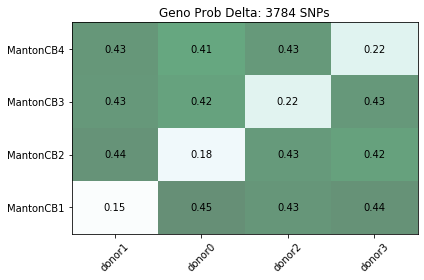

In [11]:
fig = plt.figure()
vireoSNP.plot.heat_matrix(GPb_diff[idx0, :][:, idx1], 
                          GPb0_donor_ids[idx0], 
                          GPb1_donor_ids[idx1])
plt.title("Geno Prob Delta: %d SNPs" %(len(GPb0_var_ids_use)))
plt.tight_layout()
plt.show()